In [ ]:
!pip install mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne #library untuk pemrosesan sinyal elektroensefalografi (EEG)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TA

Mounted at /content/drive
/content/drive/MyDrive/TA


In [ ]:
#3. Load data EEG dari file EDF
data1 = "/content/drive/MyDrive/TA/EDF/chb05_22.edf"
data1 = mne.io.read_raw_edf(data1)
data1

data, times = data1.get_data(return_times=True)
channel_names = data1.ch_names

#4. Ekstrak data dan simpan ke DataFrame pandas
df1 = pd.DataFrame(data.T, columns=channel_names)
df1['Time'] = times

channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3',
           'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
           'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']
time = df1['Time']

# # Step 5: Plot data EEG mentah
plt.figure(figsize=(12, 8))
for channel in channels:
    plt.plot(time, df1[channel], label=channel)

plt.title('EEG Data in Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# potong data
sample_rate = 256

# Step 6: Tentukan rentang waktu analisis
start_time_seconds = 2290
end_time_seconds = 2524

# Step 7: Potong data berdasarkan waktu -> Simpan ke CSV
start_index = int(start_time_seconds * sample_rate)
end_index = int(end_time_seconds * sample_rate)

df_1 = df1.iloc[start_index:end_index]

# Mengambil data waktu dari kolom 'Time'
time = df_1['Time']

# Membuat plot
plt.figure(figsize=(12, 8))

# Looping untuk menampilkan masing-masing saluran EEG yang dipilih
for channel in channels:
    if channel in df_1.columns:
        plt.plot(time, df_1[channel], label=channel)

# Menambahkan judul dan label
plt.title('EEG Data in Time Domain (During Seizure)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Menyimpan data yang sudah di potong
df_1.to_csv("/content/drive/MyDrive/TA/chb05_22/sampel chb05_22.csv", index=False)

print(f"Data berhasil disimpan dalam file CSV: {df_1}")

# Step 8: Tambahkan label kejang/tidak kejang -> Simpan ke CSV
# Fungsi untuk menentukan label kejang atau tidak
def label_seizure(row):
    if row['Time'] < 2348:
        return "tidak kejang"
    elif 2348 <= row['Time'] < 2465:
        return "kejang"
    else:
        return "tidak kejang"

df_1['seizure'] = df_1.apply(label_seizure, axis=1)

# Simpan data yang sudah diberi label ke file CSV
df_1.to_csv("/content/drive/MyDrive/TA/chb05_22/label chb01_03.csv", index=False)

print(f"Data yang sudah diberi label berhasil disimpan dalam file CSV: {df_1}")


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter

# Import data yang sudah dikasih label
df_1 = pd.read_csv("/content/drive/MyDrive/TA/chb05_22/label chb01_03.csv")

# Step 9: Terapkan bandpass filter -> Simpan data hasil filter ke CSV
def bandpass_filter_fir(data, lowcut, highcut, sampling_rate, num_taps):
    nyquist = 0.5 * sampling_rate
    taps = firwin(num_taps, [lowcut / nyquist, highcut / nyquist], pass_zero='bandpass', window='boxcar')
    filtered_data = lfilter(taps, 1.0, data, axis=0)
    return filtered_data

lowcut_freq = 1
highcut_freq = 50
sampling_rate = 256
num_taps = 230

# Misalnya, df_1 adalah DataFrame yang sudah ada sebelumnya
eeg_columns = df_1.columns[:-2]  # Semua kolom kecuali 'Time' dan 'seizure'
eeg_data = df_1[eeg_columns].values  # Data EEG

# Terapkan filter bandpass FIR pada data EEG
filtered_data = bandpass_filter_fir(eeg_data, lowcut_freq, highcut_freq, sampling_rate, num_taps)

TA1 = pd.DataFrame(filtered_data, columns=eeg_columns)
TA1['Time'] = df_1['Time'].values
TA1['seizure'] = df_1['seizure']

# Visualisasi data setelah filtering
plt.figure(figsize=(16, 10))

channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3',
           'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
           'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']

# Looping untuk menampilkan data dari kanal yang dipilih
for channel in channels:
    if channel in TA1.columns:
        plt.plot(TA1['Time'], TA1[channel], label=channel)

# Menambahkan judul dan label
plt.title('Filtered EEG Data in Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Simpan data setelah filtering ke file CSV
TA1.to_csv("/content/drive/MyDrive/TA/chb05_22/filtering chb01_03.csv", index=False)

print(f"Data setelah filtering berhasil disimpan dalam file CSV: {TA1}")



#SAMPEL 1 (chb01_03)

In [ ]:
import pandas as pd

# Import data filtering
df = pd.read_csv("/content/drive/MyDrive/TA/chb05_22/filtering chb01_03.csv")

# Memisahkan data berdasarkan label
TA1 = df[df['seizure'] == 'kejang']
TA2 = df[df['seizure'] == 'tidak kejang']

# Menampilkan jumlah data di masing-masing kategori
print("Jumlah data kejang:", len(TA1))
print("Jumlah data tidak kejang:", len(TA2))

# Menyimpan data ke file CSV
TA1.to_csv("/content/drive/MyDrive/TA/chb05_22/kejang chb01_03.csv", index=False)
TA2.to_csv("/content/drive/MyDrive/TA/chb05_22/no kejang chb01_03.csv", index=False)


Jumlah data kejang: 29952
Jumlah data tidak kejang: 29952


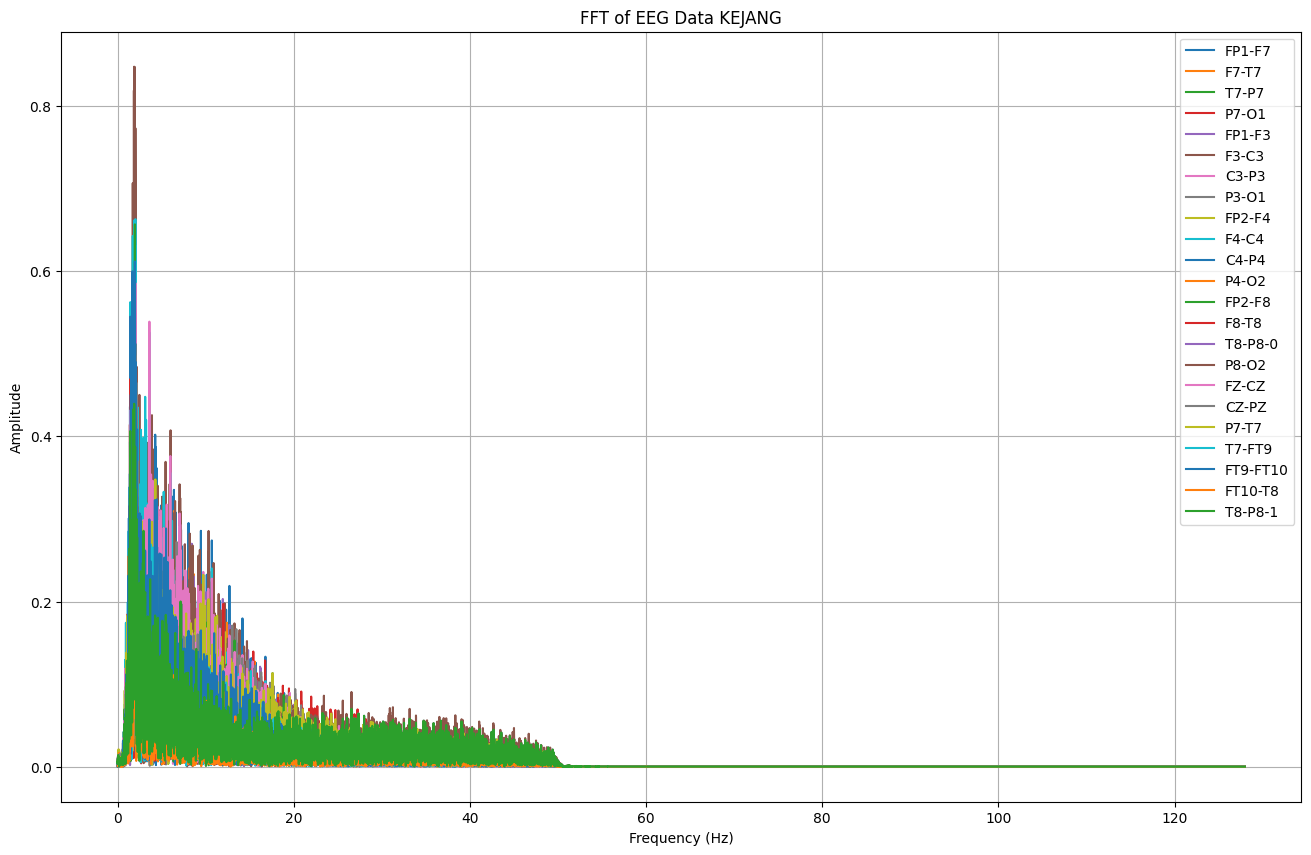

Data setelah FFT berhasil disimpan dalam file CSV:          FP1-F7     F7-T7     T7-P7     P7-O1    FP1-F3     F3-C3     C3-P3  \
0      0.000320  0.004278  0.008369  0.000504  0.002083  0.004646  0.009939   
1      0.001695  0.002565  0.006895  0.000097  0.002115  0.001932  0.008717   
2      0.001487  0.001498  0.009996  0.000690  0.004051  0.007218  0.009060   
3      0.002644  0.004049  0.010604  0.001532  0.002972  0.006219  0.010660   
4      0.006454  0.004145  0.010622  0.003292  0.002832  0.003749  0.012319   
...         ...       ...       ...       ...       ...       ...       ...   
14971  0.000116  0.000002  0.000080  0.000026  0.000067  0.000059  0.000082   
14972  0.000116  0.000002  0.000080  0.000026  0.000067  0.000059  0.000082   
14973  0.000116  0.000002  0.000080  0.000026  0.000067  0.000059  0.000082   
14974  0.000116  0.000002  0.000080  0.000026  0.000067  0.000059  0.000082   
14975  0.000116  0.000002  0.000080  0.000026  0.000067  0.000059  0.000082   



In [ ]:
TA1 = pd.read_csv("/content/drive/MyDrive/TA/chb05_22/kejang chb01_03.csv")

channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3',
           'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
           'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']
sampling_rate = 256

# Step 10: Hitung FFT data EEG -> Simpan hasil ke CSV
# FFT dan ekstraksi fitur
def compute_fft(signal, sampling_rate):
    N = len(signal)
    T = 1.0 / sampling_rate
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(N, T)
    fft_vals = np.abs(fft_vals[:N // 2])
    fft_freqs = fft_freqs[:N // 2]
    return fft_freqs, fft_vals

# Ekstraksi fitur FFT
fft_features = []
for channel in channels:
    if channel in TA1.columns:
        signal = TA1[channel].values
        fft_freqs, fft_vals = compute_fft(signal, sampling_rate)
        fft_features.append(fft_vals)

# Mengubah fitur FFT menjadi DataFrame
TA_1 = pd.DataFrame(fft_features).T
TA_1.columns = channels
TA_1['seizure'] = TA1['seizure']
TA_1['frekuensi'] = fft_freqs  # Masukkan frekuensi sebagai kolom pertama


# Visualisasi data setelah FFT
plt.figure(figsize=(16, 10))

# Looping untuk menampilkan spektrum frekuensi dari kanal yang dipilih
for channel in channels:
    if channel in TA_1.columns:  # Memastikan kanal ada dalam data
        fft_freqs, fft_vals = compute_fft(TA1[channel].values, sampling_rate)
        plt.plot(fft_freqs, fft_vals, label=channel)

# Menambahkan judul dan label
plt.title('FFT of EEG Data KEJANG')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Simpan data KEJANG setelah FFT ke file CSV
TA_1.to_csv("/content/drive/MyDrive/TA/chb05_22/kejang chb01_03.csv", index=False)

print(f"Data setelah FFT berhasil disimpan dalam file CSV: {TA_1}")

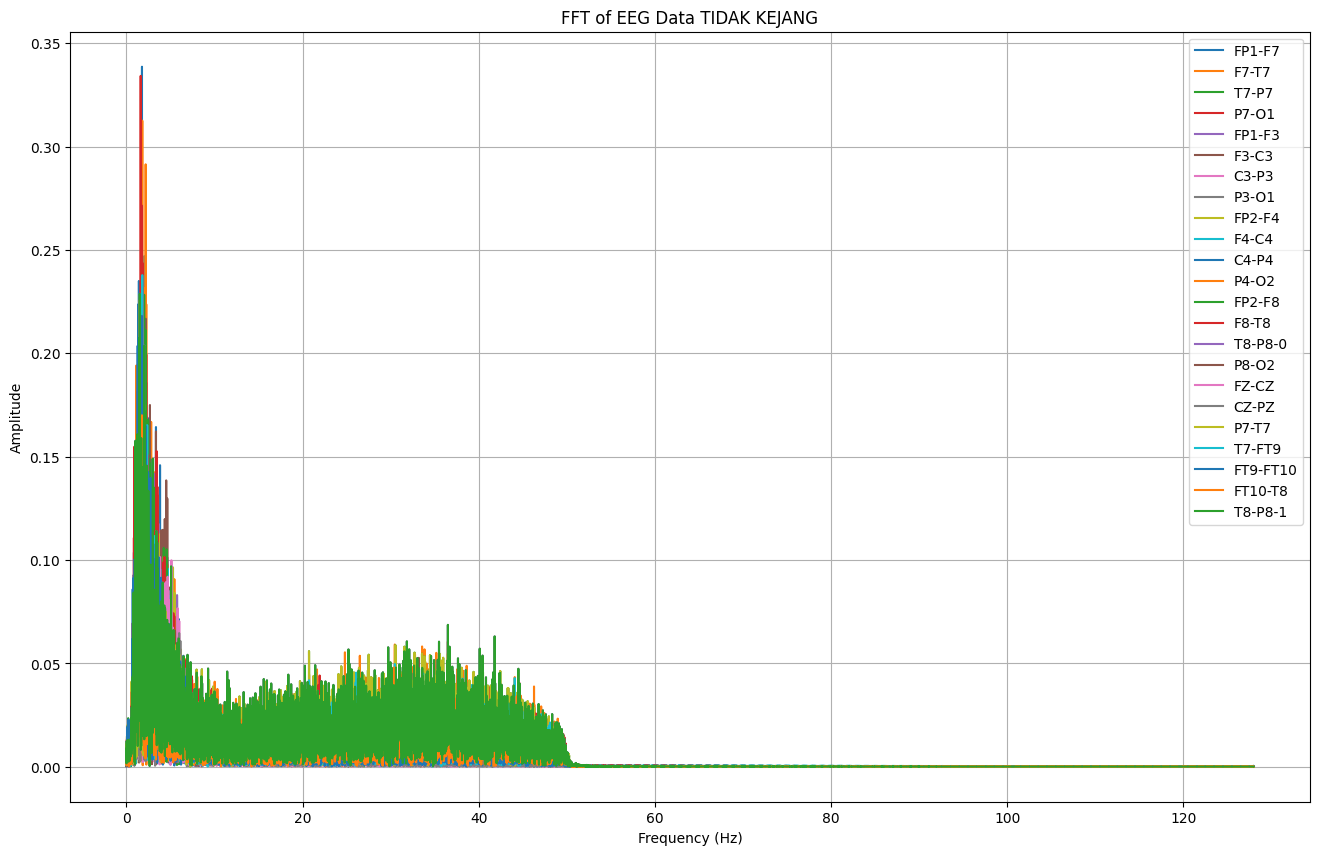

Data setelah FFT berhasil disimpan dalam file CSV:          FP1-F7     F7-T7     T7-P7     P7-O1    FP1-F3     F3-C3     C3-P3  \
0      0.000120  0.002494  0.008749  0.001932  0.001043  0.004163  0.007383   
1      0.003043  0.002050  0.006668  0.000199  0.004041  0.001147  0.010079   
2      0.001739  0.003313  0.010556  0.001374  0.000993  0.004818  0.008031   
3      0.003335  0.002186  0.009137  0.001625  0.002869  0.001570  0.011165   
4      0.003033  0.007057  0.011046  0.002612  0.003610  0.002852  0.008516   
...         ...       ...       ...       ...       ...       ...       ...   
14971  0.000037  0.000046  0.000086  0.000044  0.000035  0.000028  0.000067   
14972  0.000197  0.000050  0.000075  0.000008  0.000167  0.000091  0.000096   
14973  0.000035  0.000046  0.000086  0.000044  0.000034  0.000027  0.000067   
14974  0.000198  0.000050  0.000075  0.000008  0.000167  0.000092  0.000096   
14975  0.000034  0.000046  0.000086  0.000044  0.000033  0.000027  0.000067   



In [ ]:
TA2 = pd.read_csv("/content/drive/MyDrive/TA/chb05_22/no kejang chb01_03.csv")

channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3',
           'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
           'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']
sampling_rate = 256

# Step 10: Hitung FFT data EEG -> Simpan hasil ke CSV
# FFT dan ekstraksi fitur
def compute_fft(signal, sampling_rate):
    N = len(signal)
    T = 1.0 / sampling_rate
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(N, T)
    fft_vals = np.abs(fft_vals[:N // 2])
    fft_freqs = fft_freqs[:N // 2]
    return fft_freqs, fft_vals

# Ekstraksi fitur FFT
fft_features = []
for channel in channels:
    if channel in TA2.columns:
        signal = TA2[channel].values
        fft_freqs, fft_vals = compute_fft(signal, sampling_rate)
        fft_features.append(fft_vals)

# Mengubah fitur FFT menjadi DataFrame
TA_2 = pd.DataFrame(fft_features).T
TA_2.columns = channels
TA_2['seizure'] = TA2['seizure']
TA_2['frekuensi'] = fft_freqs

# Visualisasi data setelah FFT
plt.figure(figsize=(16, 10))

# Looping untuk menampilkan spektrum frekuensi dari kanal yang dipilih
for channel in channels:
    if channel in TA_2.columns:  # Memastikan kanal ada dalam data
        fft_freqs, fft_vals = compute_fft(TA2[channel].values, sampling_rate)
        plt.plot(fft_freqs, fft_vals, label=channel)

# Menambahkan judul dan label
plt.title('FFT of EEG Data TIDAK KEJANG')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Simpan data TIDAK KEJANG setelah FFT ke file CSV
TA_2.to_csv("/content/drive/MyDrive/TA/chb05_22/no kejang chb01_03.csv", index=False)

print(f"Data setelah FFT berhasil disimpan dalam file CSV: {TA_2}")


Data berhasil digabung dan disimpan sebagai df_gabungan.csv!
Jumlah data seizure dan tidak seizure:
seizure
kejang          14976
tidak kejang    14976
Name: count, dtype: int64


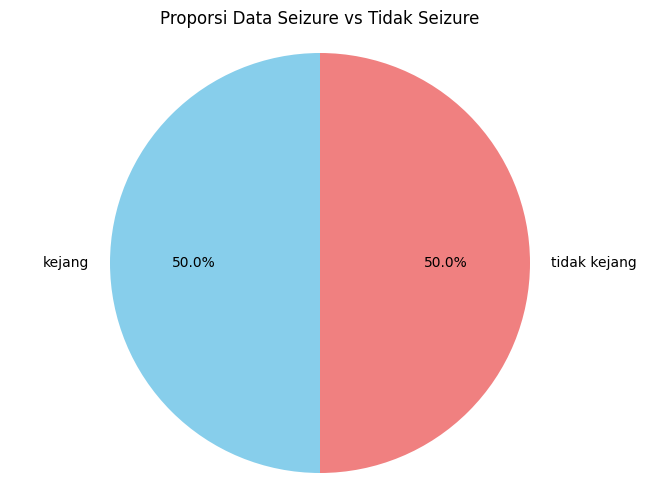

In [ ]:
# Menggabungkan data KEJANG & TIDAK KEJANG
TA_gabungan = pd.concat([TA_1, TA_2], ignore_index=True)

# Menyimpan kembali data gabungan ke file CSV
TA_gabungan.to_csv("/content/drive/MyDrive/TA/chb05_22/fft chb01_03.csv", index=False)

print("Data berhasil digabung dan disimpan sebagai df_gabungan.csv!")

# Menghitung jumlah masing-masing label (seizure dan tidak seizure)
seizure_counts = TA_gabungan['seizure'].value_counts()

# Menampilkan jumlah data seizure dan tidak seizure
print("Jumlah data seizure dan tidak seizure:")
print(seizure_counts)

# Membuat pie chart
plt.figure(figsize=(8, 6))
plt.pie(seizure_counts, labels=seizure_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Proporsi Data Seizure vs Tidak Seizure')
plt.axis('equal')  # Menjaga proporsi lingkaran tetap
plt.show()

Nilai Maksimum Delta (Kejang): 8.1128
Nilai Maksimum Theta (Kejang): 3.7786
Nilai Maksimum Alpha (Kejang): 2.3770
Nilai Maksimum Beta (Kejang): 1.5868
Nilai Maksimum Gamma (Kejang): 0.4662
Nilai Maksimum Delta (Normal): 2.9247
Nilai Maksimum Theta (Normal): 1.2241
Nilai Maksimum Alpha (Normal): 0.4083
Nilai Maksimum Beta (Normal): 0.4239
Nilai Maksimum Gamma (Normal): 0.4760


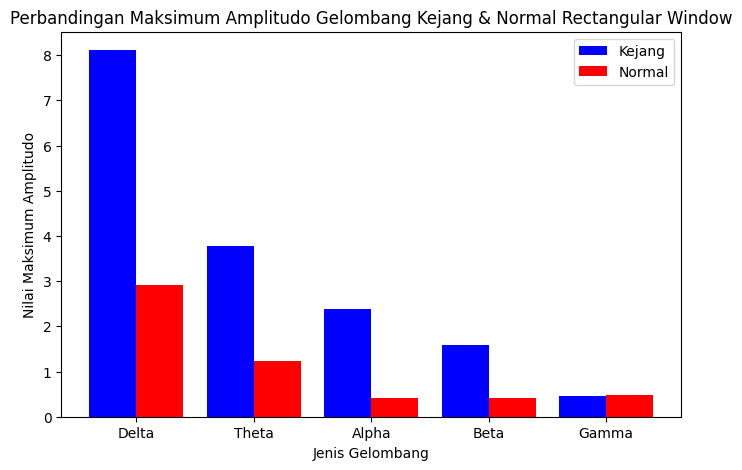

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data 1
file_path1 = "/content/drive/MyDrive/TA/chb05_22/kejang chb01_03.csv"
data1 = pd.read_csv(file_path1)

# Load data 2
file_path2 = "/content/drive/MyDrive/TA/chb05_22/no kejang chb01_03.csv"
data2 = pd.read_csv(file_path2)

# Pastikan kolom yang berisi frekuensi dan amplitudo sesuai dengan dataset Anda
frequencies1 = data1['frekuensi']
frequencies2 = data2['frekuensi']

# Daftar channel EEG
channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3',
            'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
            'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']

# Definisikan rentang frekuensi masing-masing gelombang
bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 50)
}

def get_band_max(frequencies, amplitudes, band):
    mask = (frequencies >= band[0]) & (frequencies < band[1])
    return np.max(amplitudes[mask]) if np.any(mask) else 0

# Menghitung nilai maksimum untuk masing-masing gelombang secara keseluruhan (tidak dipisah per channel)
total_amplitudes1 = data1[channels].sum(axis=1)
total_amplitudes2 = data2[channels].sum(axis=1)

band_max1 = {band: get_band_max(frequencies1, total_amplitudes1, bands[band]) for band in bands}
band_max2 = {band: get_band_max(frequencies2, total_amplitudes2, bands[band]) for band in bands}

# Tampilkan hasil
for band, max_val in band_max1.items():
    print(f"Nilai Maksimum {band} (Kejang): {max_val:.4f}")
for band, max_val in band_max2.items():
    print(f"Nilai Maksimum {band} (Normal): {max_val:.4f}")

# Visualisasi hasil
plt.figure(figsize=(8, 5))
bar_width = 0.4
index = np.arange(len(bands))

plt.bar(index, band_max1.values(), bar_width, label='Kejang', color='blue')
plt.bar(index + bar_width, band_max2.values(), bar_width, label='Normal', color='red')

plt.xlabel("Jenis Gelombang")
plt.ylabel("Nilai Maksimum Amplitudo")
plt.title("Perbandingan Maksimum Amplitudo Gelombang Kejang & Normal Rectangular Window")
plt.xticks(index + bar_width / 2, bands.keys())
plt.legend()
plt.show()
